<a href="https://colab.research.google.com/github/GulnazAleksashova/go-off/blob/main/Aug__VGG16_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Achieve at least 85% accuracy on a validation set for three classes of cars. The size of the validation set is 20%.

In [1]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,  Flatten, Dropout

from tensorflow.keras.applications import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, \
                                       ReduceLROnPlateau
from tensorflow.keras import utils 
from tensorflow.keras.preprocessing import image 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image 
import random 
import math 
import os 

import gdown 
                                                                  
%matplotlib inline

In [2]:
# Downloading the file from the link
gdown.download('https://storage.googleapis.com/datasets_ai/Base/5_Conv/middle_fmr.zip', None, quiet=True) 

'middle_fmr.zip'

In [3]:
# Unzip DataBase to 'cars' folder
!unzip -q 'middle_fmr.zip' -d '/content/cars'

In [19]:
# Hyperparameters
TRAIN_PATH = '/content/cars'      # Path to the dir with  train pictures
TEST_PATH = '/content/cars_test'  #  Path to the dir with  test pictures

TEST_SPLIT = 0.2                  # Part of test data in the total set
VAL_SPLIT = 0.2                   # Part of validation data in the train set

IMG_WIDTH = 224                   # Image width for a neural network
IMG_HEIGHT = 224                  # Image height for a neural network
BATCH_SIZE = 24                   # Batch size for training
OPTIMIZER = Adam(learning_rate=1e-6)
EPOCHS = 100

# Augmentation parameters
ROTATION_RANGE = 8                # Rotation limit
WIDTH_SHIFT_RANGE = 0.2          # Horizontal shift limits
HEIGHT_SHIFT_RANGE = 0.2         # Vertical shift limits
ZOOM_RANGE = 0.15                 # Zooming limits
BRIGHTNESS_RANGE = (0.7, 1.3)     # Brightness limits
HORIZONTAL_FLIP = True            # Horizontal reflection allowed

In [5]:
# A list of class names
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Number of classes
CLASS_COUNT = len(CLASS_LIST)

print(f'Number of classes: {CLASS_COUNT}, labels of classes: {CLASS_LIST}')

Number of classes: 3, labels of classes: ['Ferrari', 'Mercedes', 'Renault']


In [6]:
# Dividing the complete dataset into training and test sets
os.mkdir(TEST_PATH)                                        # Folder for test data
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              
    class_path = f'{TRAIN_PATH}/{class_name}'              # Full dir path of each class
    test_path = f'{TEST_PATH}/{class_name}'                # Full path for test data of each class
    class_files = os.listdir(class_path)                   # A list of filenames with images of the current class
    class_file_count = len(class_files)                    # Total number of files in a class
    os.mkdir(test_path)                                    # A class subfolder for test data
    test_file_count = int(class_file_count * TEST_SPLIT)   # The number of test data for a class
    test_files = class_files[-test_file_count:]            
    for f in test_files:                                   # Moving test data to the test folder
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        
    test_count += test_file_count                          

    print(f'Class of {class_name}: {class_file_count} cars, test data consist: {test_file_count}')

print(f'Total number of data: {train_count}, training data: {train_count - test_count}, test data: {test_count}')

Class of Ferrari: 1088 cars, test data consist: 217
Class of Mercedes: 1161 cars, test data consist: 232
Class of Renault: 1178 cars, test data consist: 235
Total number of data: 3427, training data: 2743, test data: 684


In [7]:
# Image Generators
datagen1 = ImageDataGenerator(
                    rescale=1. / 255,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                    )

datagen2 = ImageDataGenerator(
                    rescale=1. / 255,
                    validation_split=VAL_SPLIT
                    )


datagen3 = ImageDataGenerator(
    rescale=1. / 255
)

In [8]:
# Data generator for training
train_generator = datagen1.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
    )

# Data generator for validation of training prosses
val_generator = datagen2.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
    )

# Data generator for testing model
test_generator = datagen3.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
    )

Found 2196 images belonging to 3 classes.
Found 547 images belonging to 3 classes.
Found 684 images belonging to 3 classes.


In [9]:
# Callbacks
checkpoint = [
             ModelCheckpoint('/content/drive/My Drive/Models/Cars_vgg16_new.hdf5', 
             monitor='val_loss', 
             save_best_only=True)
             ]
early = EarlyStopping(monitor='val_loss', patience=5, mode='auto')
lr_reduce = ReduceLROnPlateau(
                           monitor='val_loss',
                           patience=5, 
                           verbose=0, 
                           mode='auto'
                           )

In [20]:
# Function of compilation and training of a neural network model
def compile_train_model(model,                  
                        train_data,             
                        val_data,               
                        optimizer=OPTIMIZER,    
                        epochs=EPOCHS,          
                        batch_size=BATCH_SIZE, 
                        figsize=(20, 5)):       

    # Model compilation
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Model train
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data,
                        callbacks=[early,checkpoint,lr_reduce])

    # Visualization of the training process 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Graph of the training process')
    ax1.plot(history.history['accuracy'], 
               label='Part of the right answers on the training set')
    ax1.plot(history.history['val_accuracy'], 
               label='Part of the right answers on the validation set')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Epoch of the training')
    ax1.set_ylabel('Part of the right answers')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Error on the training set')
    ax2.plot(history.history['val_loss'], 
               label='Error on the validation set')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Epoch of the training')
    ax2.set_ylabel('Error')
    ax2.legend()
    plt.show()

In [21]:
# Output of the model evaluation results on the given data
def eval_model(model, 
               x,                # model prediction data (input)
               y_true,           # valid class labels in OHE format (output)
               class_labels=[],  # 
               cm_round=2,       # 
               title='',         # 
               figsize=(5, 5)    # size of confusion matrix
               ):
    # Model prediction
    y_pred = model.predict(x)
    # Confusion matrix
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    cm = np.around(cm, cm_round)

    # Graph of confusion matrix
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Neural network {title}: normilized confusion matrix', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()      
    fig.autofmt_xdate(rotation=90)        
    plt.xlabel('Predicted classes', fontsize=16)
    plt.ylabel('Actual classes', fontsize=16)
    plt.show()    

    print('-'*100)
    print(f'Neural network: {title}')

    # For each class:
    for cls in range(len(class_labels)):
        # The index of the class with the maximum prediction (confidence) value 
        cls_pred = np.argmax(cm[cls])
        # A message about the correctness or incorrectness of the prediction
        msg = 'Correct' if cls_pred == cls else 'Incorrect'
        # Text message about predicted class
        print('Class: {:<20} {:3.0f}% neural networ predicted as a class {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # The average recognition accuracy ( the average of the diagonal elements of the error matrix)
    print('\nThe average recognition accuracy: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [22]:
# Full fuction of training and evaluating a model

def compile_train_eval_model(model,                    
                             train_data,               
                             val_data,                 
                             test_data,                
                             class_labels=CLASS_LIST,  
                             title='',                 
                             optimizer=OPTIMIZER,      
                             epochs=EPOCHS,            
                             batch_size=BATCH_SIZE,    
                             graph_size=(20, 5),       
                             cm_size=(6, 6)          
                             ):

    compile_train_model(model, 
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Evaluating model performance on test data
    eval_model(model, test_data[0][0], test_data[0][1], 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

In [13]:
# Loading the pretrained model
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)
                  )

58900480/58889256 [==============================] - 1s 0us/step


In [14]:
# Freezing the weights of the pretrained neural network
vgg16_net.trainable = False

vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# Creating a composite neural network based on the VGG16 model
model = Sequential()
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.1))  
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 27,561,795
Trainable params: 12,847,107
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/100
92/92 [==============================] - 45s 483ms/step - loss: 0.3382 - accuracy: 0.8780 - val_loss: 0.4752 - val_accuracy: 0.8227 - lr: 1.0000e-07
Epoch 2/100
92/92 [==============================] - 44s 481ms/step - loss: 0.3429 - accuracy: 0.8730 - val_loss: 0.4745 - val_accuracy: 0.8245 - lr: 1.0000e-07
Epoch 3/100
92/92 [==============================] - 45s 483ms/step - loss: 0.3381 - accuracy: 0.8798 - val_loss: 0.4742 - val_accuracy: 0.8263 - lr: 1.0000e-07
Epoch 4/100
92/92 [==============================] - 44s 481ms/step - loss: 0.3321 - accuracy: 0.8852 - val_loss: 0.4744 - val_accuracy: 0.8263 - lr: 1.0000e-07
Epoch 5/100
92/92 [==============================] - 45s 484ms/step - loss: 0.3341 - accuracy: 0.8748 - val_loss: 0.4744 - val_accuracy: 0.8263 - lr: 1.0000e-07
Epoch 6/100
92/92 [==============================] - 45s 486ms/step - loss: 0.3401 - accuracy: 0.8752 - val_loss: 0.4746 - val_accuracy: 0.8245 - lr: 1.0000e-07
Epoch 7/100
92/92 [===============

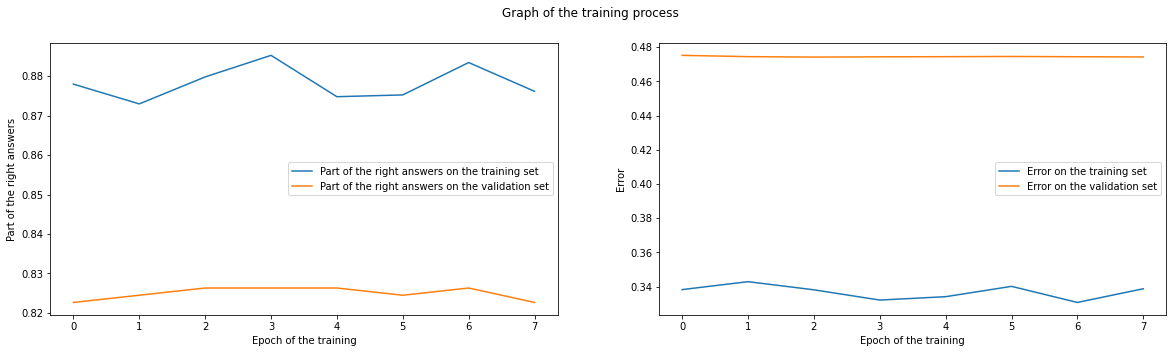

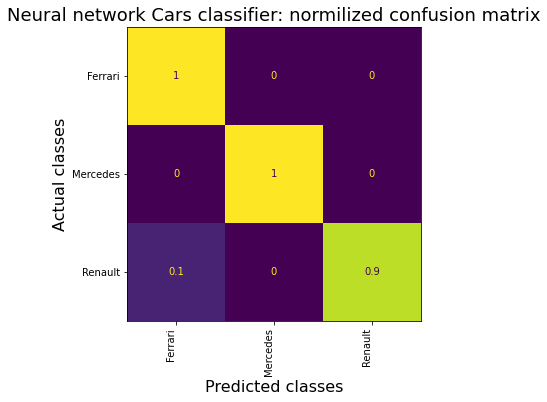

----------------------------------------------------------------------------------------------------
Neural network: Cars classifier
Class: Ferrari              100% neural networ predicted as a class Ferrari              - Correct
Class: Mercedes             100% neural networ predicted as a class Mercedes             - Correct
Class: Renault               90% neural networ predicted as a class Renault              - Correct

The average recognition accuracy:  97%


In [18]:
# Trainig of the model
compile_train_eval_model(model,
                         train_generator,
                         val_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Cars classifier')

In [23]:
# Fine tuning
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 27,561,795
Trainable params: 19,926,531
Non-trainable params: 7,635,264
_________________________________________________________________


Epoch 1/100
92/92 [==============================] - 48s 500ms/step - loss: 0.3310 - accuracy: 0.8807 - val_loss: 0.4733 - val_accuracy: 0.8227 - lr: 1.0000e-06
Epoch 2/100
92/92 [==============================] - 45s 492ms/step - loss: 0.3238 - accuracy: 0.8793 - val_loss: 0.4745 - val_accuracy: 0.8172 - lr: 1.0000e-06
Epoch 3/100
92/92 [==============================] - 46s 496ms/step - loss: 0.3049 - accuracy: 0.8834 - val_loss: 0.4696 - val_accuracy: 0.8227 - lr: 1.0000e-06
Epoch 4/100
92/92 [==============================] - 45s 488ms/step - loss: 0.3054 - accuracy: 0.8834 - val_loss: 0.4699 - val_accuracy: 0.8245 - lr: 1.0000e-06
Epoch 5/100
92/92 [==============================] - 46s 495ms/step - loss: 0.2898 - accuracy: 0.8884 - val_loss: 0.4681 - val_accuracy: 0.8300 - lr: 1.0000e-06
Epoch 6/100
92/92 [==============================] - 45s 487ms/step - loss: 0.3048 - accuracy: 0.8784 - val_loss: 0.4719 - val_accuracy: 0.8263 - lr: 1.0000e-06
Epoch 7/100
92/92 [===============

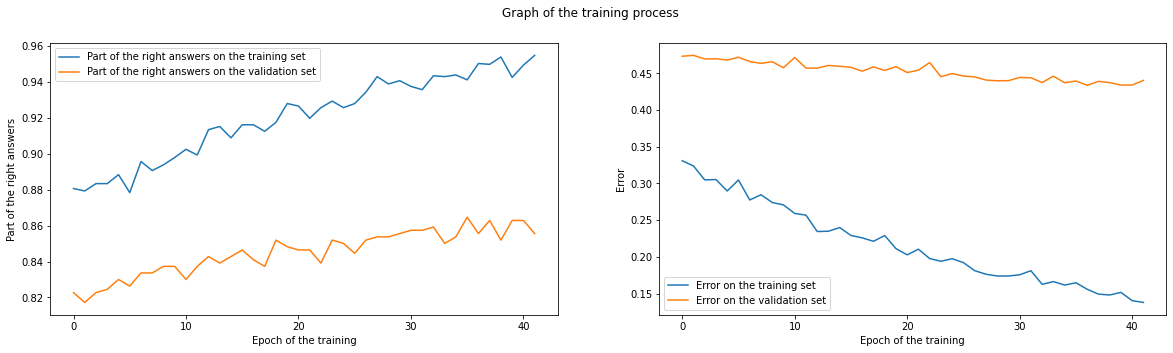

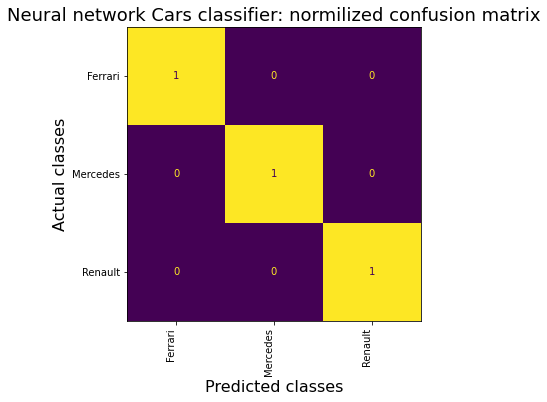

----------------------------------------------------------------------------------------------------
Neural network: Cars classifier
Class: Ferrari              100% neural networ predicted as a class Ferrari              - Correct
Class: Mercedes             100% neural networ predicted as a class Mercedes             - Correct
Class: Renault              100% neural networ predicted as a class Renault              - Correct

The average recognition accuracy: 100%


In [25]:
compile_train_eval_model(model,
                         train_generator,
                         val_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Cars classifier')